In [ ]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import os
import pandas as pd
import fastf1 as ff1
import keras
# import plotly

Weather Index Difficulty Attempt

### Track Difficulty Index Attempt

Data Processing

In [12]:
# f1_sql_to_pandas.py
# Converts the BigQuery-style SQL snippets from the notebook into pandas operations on Kaggle F1 CSVs.

from pathlib import Path
import pandas as pd
import numpy as np

# Update this to your Kaggle dataset directory
DATA_DIR = Path(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1 kaggle data")  # e.g., folder with results.csv, races.csv, status.csv

def load_csv(name_candidates):
    for name in name_candidates:
        p = DATA_DIR / name
        if p.exists():
            return pd.read_csv(p)
    raise FileNotFoundError(f"None of these files were found in {DATA_DIR}: {name_candidates}")

# Load base tables
results = load_csv(["results.csv"])
races = load_csv(["races.csv"])
# status is optional; not required for the queries below, but often useful
status_df = None
try:
    status_df = load_csv(["status.csv", "statuses.csv", "status_codes.csv"])
except FileNotFoundError:
    pass  # Not needed for these conversions

# ---- SQL #1 ----
# SELECT DISTINCT position, position_text FROM Results ORDER BY position
distinct_positions = (
    results.loc[:, ["position", "positionText"]]
    .drop_duplicates()
)
# Sort by numeric position when possible, then fallback to string
distinct_positions["_pos_sort"] = pd.to_numeric(distinct_positions["position"], errors="coerce")
distinct_positions = distinct_positions.sort_values(
    by=["_pos_sort", "position"], kind="mergesort"
).drop(columns=["_pos_sort"])
print("SQL #1 result (distinct positions):")
print(distinct_positions.head(20), "\n")

# ---- SQL #2 ----
# Validate numeric casts similar to SAFE_CAST check (rows where cast would become NULL/NaN)
cols_to_cast = ["grid", "positionOrder", "resultId", "raceId", "driverId", "constructorId", "number"]
casted = {}
for c in cols_to_cast:
    if c in results.columns:
        casted[c] = pd.to_numeric(results[c], errors="coerce")
    else:
        # create a series of NaN if column missing
        casted[c] = pd.Series([np.nan] * len(results), index=results.index)

cast_df = pd.DataFrame(casted)
# Identify rows where any of the conversions resulted in NaN (failed casts)
invalid_casts_mask = cast_df.isna().any(axis=1)
invalid_casts = pd.concat([cast_df, results[cols_to_cast]], axis=1, join="inner").loc[invalid_casts_mask]
print(f"SQL #2 result: rows with failed numeric casts: {invalid_casts.shape[0]}")
print(invalid_casts.head(10), "\n")

# ---- SQL #3 ----
# SELECT resultId, COUNT(*) as count FROM Results GROUP BY resultId HAVING COUNT(*) > 1
if "resultId" in results.columns:
    dup_counts = (
        results.groupby("resultId", dropna=False)
        .size().reset_index(name="count")
        .query("count > 1")
        .sort_values("count", ascending=False)
    )
else:
    dup_counts = pd.DataFrame(columns=["resultId", "count"])
print("SQL #3 result (duplicate resultId counts > 1):")
print(dup_counts.head(20), "\n")

# ---- SQL #4 ----
# SELECT r.*, ra.year, ra.name AS race_name, ra.circuitId FROM Results r JOIN Races ra ON r.raceId = ra.raceId
race_cols = ["raceId", "year", "name", "circuitId"]
present_cols = [c for c in race_cols if c in races.columns]
results_with_race = results.merge(races[present_cols], on="raceId", how="left")
if "name" in results_with_race.columns:
    results_with_race = results_with_race.rename(columns={"name": "race_name"})
print("SQL #4 result (results joined with races):", results_with_race.shape, "\n")

# ---- SQL #5 ----
# SELECT * FROM Races_with_year WHERE year > 2013
if "year" in results_with_race.columns:
    races_with_year = results_with_race[results_with_race["year"] > 2013].copy()
else:
    races_with_year = results_with_race.copy()
print("SQL #5 result (races_with_year where year > 2013):", races_with_year.shape, "\n")

# ---- SQL #6 ----
# SELECT DISTINCT status id FROM races_with_year ORDER BY status id
status_col = "statusId" if "statusId" in races_with_year.columns else None
if status_col:
    distinct_status_ids = (
        pd.DataFrame({status_col: races_with_year[status_col]})
        .drop_duplicates()
        .sort_values(status_col, kind="mergesort")
        .reset_index(drop=True)
    )
else:
    distinct_status_ids = pd.DataFrame(columns=["statusId"])
print("SQL #6 result (distinct statusId):")
print(distinct_status_ids.head(50), "\n")

# ---- SQL #7 ----
# CASE mapping of statusId → race_results category
def map_status_category(sid):
    try:
        sid = int(sid)
    except (TypeError, ValueError):
        return "Unknown"
    # Ported from the SQL CASE
    if sid == 1:
        return "Finish"
    if sid == 2:
        return "Disqualification"
    if sid in (3, 20):
        return "Accident"
    if sid in (4, 130):
        return "Collision"
    if 21 <= sid <= 79:
        return "Mechanical or Physical Fault"
    if sid in {5, 6, 7, 8, 9, 10, 21, 79, 84, 95, 101, 103, 105, 131, 132, 135, 136, 141}:
        return "Mechanical or Physical Fault"
    if 11 <= sid <= 19:
        return "Behind on Laps"
    if sid in {137, 138, 140}:
        return "Damage Related"
    if sid in {139, 96}:
        return "Other"
    return "Unknown"

if status_col:
    races_with_year["race_results"] = races_with_year[status_col].map(map_status_category)
    print("SQL #7 result: race_results value counts:")
    print(races_with_year["race_results"].value_counts(dropna=False).head(20), "\n")
else:
    print("SQL #7 skipped: no statusId column present.\n")

# Optional: show a small preview of transformed data
print("Preview of races_with_year with mapped race_results:")
preview_cols = [c for c in ["raceId", "year", "race_name", "circuitId", "statusId", "race_results"] if c in races_with_year.columns]
# print(races_with_year[preview_cols].head(10))

SQL #1 result (distinct positions):
    position positionText
0          1            1
1          2            2
2          3            3
3          4            4
4          5            5
5          6            6
6          7            7
7          8            8
30         9            9
31        10           10
32        11           11
33        12           12
34        13           13
35        14           14
36        15           15
37        16           16
38        17           17
61        18           18
62        19           19
629       20           20 

SQL #2 result: rows with failed numeric casts: 6
       grid  positionOrder  resultId  raceId  driverId  constructorId number  \
17715     0             19     17716     732       459             66    NaN   
17716     0             20     17717     732       462             95    NaN   
17717     0             21     17718     732       446            172    NaN   
17718     0             22     17719     732   

In [16]:
races_with_year["race_name"].unique()

array(['Australian Grand Prix', 'Malaysian Grand Prix',
       'Bahrain Grand Prix', 'Chinese Grand Prix', 'Spanish Grand Prix',
       'Monaco Grand Prix', 'Canadian Grand Prix', 'Austrian Grand Prix',
       'British Grand Prix', 'German Grand Prix', 'Hungarian Grand Prix',
       'Belgian Grand Prix', 'Italian Grand Prix', 'Singapore Grand Prix',
       'Japanese Grand Prix', 'Russian Grand Prix',
       'United States Grand Prix', 'Brazilian Grand Prix',
       'Abu Dhabi Grand Prix', 'Mexican Grand Prix',
       'European Grand Prix', 'Azerbaijan Grand Prix',
       'French Grand Prix', 'Styrian Grand Prix',
       '70th Anniversary Grand Prix', 'Tuscan Grand Prix',
       'Eifel Grand Prix', 'Portuguese Grand Prix',
       'Emilia Romagna Grand Prix', 'Turkish Grand Prix',
       'Sakhir Grand Prix', 'Dutch Grand Prix', 'Mexico City Grand Prix',
       'São Paulo Grand Prix', 'Qatar Grand Prix',
       'Saudi Arabian Grand Prix', 'Miami Grand Prix',
       'Las Vegas Grand Prix']

BAR CHART of Race Statues

In [13]:
# ---- NEW SECTION: Plot race status counts per Grand Prix (Plotly) ----
import plotly.express as px

# ---- Drop rows based on race_results category ----
# Example: remove all "Finish" and "Behind on Laps" rows
categories_to_drop = ["Other"]
races_with_year_dropped = races_with_year[~races_with_year["race_results"].isin(categories_to_drop)].copy()

if "race_results" in races_with_year_dropped.columns and "race_name" in races_with_year_dropped.columns:
    # Count race result categories per Grand Prix
    status_counts = (
        races_with_year_dropped.groupby(["race_name", "race_results"])
        .size()
        .reset_index(name="count")
    )

    # Create interactive stacked bar chart
    fig = px.bar(
        status_counts,
        x="race_name",
        y="count",
        color="race_results",
        title="Count of Race Status Categories per Grand Prix",
        labels={"race_name": "Grand Prix", "count": "Count of Race Statuses"},
        text="count"
    )

    # Improve layout
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis_title="Grand Prix",
        yaxis_title="Count of Race Statuses",
        legend_title="Race Result Category",
        barmode="stack",
        width=1100,
        height=600,
        template="plotly_white",
        margin=dict(l=40, r=40, t=60, b=120)
    )

    fig.show()
else:
    print("Cannot plot: missing 'race_results' or 'race_name' column.")


In [11]:
# ---- NEW SECTION: Plot race status counts per Grand Prix (Plotly) ----
import plotly.express as px

# ---- Drop rows based on race_results category ----
# Example: remove all "Finish" and "Behind on Laps" rows
categories_to_drop = ["Other", "Behind on Laps", "Disqualification"]
races_with_year_dropped = races_with_year[~races_with_year["race_results"].isin(categories_to_drop)].copy()

if "race_results" in races_with_year_dropped.columns and "race_name" in races_with_year_dropped.columns:
    # Count race result categories per Grand Prix
    status_counts = (
        races_with_year_dropped.groupby(["race_name", "race_results"])
        .size()
        .reset_index(name="count")
    )

    # Create interactive stacked bar chart
    fig = px.bar(
        status_counts,
        x="race_name",
        y="count",
        color="race_results",
        title="Count of Race Status Categories per Grand Prix",
        labels={"race_name": "Grand Prix", "count": "Count of Race Statuses"},
        text="count"
    )

    # Improve layout
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis_title="Grand Prix",
        yaxis_title="Count of Race Statuses",
        legend_title="Race Result Category",
        barmode="stack",
        width=1100,
        height=600,
        template="plotly_white",
        margin=dict(l=40, r=40, t=60, b=120)
    )

    fig.show()
else:
    print("Cannot plot: missing 'race_results' or 'race_name' column.")


BAR CHART of Damages Assumed to be caused by Circuit Type

In [15]:
# ---- NEW SECTION: Plot race status counts per Grand Prix (Plotly) ----
import plotly.express as px

# ---- Drop rows based on race_results category ----
# Example: remove all "Finish" and "Behind on Laps" rows
categories_to_drop = ["Other", "Behind on Laps", "Disqualification","Finish","Mechanical or Physical Fault"]
races_with_year_dropped = races_with_year[~races_with_year["race_results"].isin(categories_to_drop)].copy()

if "race_results" in races_with_year_dropped.columns and "race_name" in races_with_year_dropped.columns:
    # Count race result categories per Grand Prix
    status_counts = (
        races_with_year_dropped.groupby(["race_name", "race_results"])
        .size()
        .reset_index(name="count")
    )

    # Create interactive stacked bar chart
    fig = px.bar(
        status_counts,
        x="race_name",
        y="count",
        color="race_results",
        title="Count of Race Status Categories per Grand Prix",
        labels={"race_name": "Grand Prix", "count": "Count of Race Statuses"},
        text="count"
    )

    # Improve layout
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis_title="Grand Prix",
        yaxis_title="Count of Race Statuses",
        legend_title="Race Result Category",
        barmode="stack",
        width=1100,
        height=600,
        template="plotly_white",
        margin=dict(l=40, r=40, t=60, b=120)
    )

    fig.show()
else:
    print("Cannot plot: missing 'race_results' or 'race_name' column.")


In [1]:
import fastf1

circuit = fastf1.get_circuit_info(2024, 'Monaco')
print(circuit)


AttributeError: module 'fastf1' has no attribute 'get_circuit_info'

In [17]:
import fastf1

session = fastf1.get_session(2024, 'Monaco', 'Race')
session.load()
circuit = fastf1.get_circuit_info(2024, 'Monaco')

circuit_info = {
    "Name": circuit.name,
    "Country": circuit.country,
    "Length (km)": circuit.length / 1000,
    "Turns": circuit.turns,
    "Direction": circuit.direction,
    "DRS Zones": circuit.drs_zones,
    "Race Distance (km)": (circuit.length * session.total_laps) / 1000
}

print(circuit_info)


req         WARNING 	DEFAULT CACHE ENABLED! (519.71 MB) C:\Users\Enzo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track

AttributeError: module 'fastf1' has no attribute 'get_circuit_info'

In [4]:
import fastf1
print("FastF1 version:", fastf1.__version__)

session = fastf1.get_session(2024, 'Monaco', 'Race')
session.load()

# Try accessing circuit info
try:
    circuit = session.get_circuit_info()
    print(circuit)
    print("Attributes:", dir(circuit))
except AttributeError as e:
    print("get_circuit_info not available:", e)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


FastF1 version: 3.6.1


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


CircuitInfo(corners=              X            Y  Number Letter       Angle     Distance
0  -7381.106934 -4719.949219       1         140.384631   185.712871
1  -3634.549072 -3769.346436       2         103.015117   569.518924
2  -2275.649414 -3071.900879       3         168.949842   743.272585
3  -2745.113281 -1956.109497       4        -174.396257   866.769924
4  -1422.224854  -197.893692       5          76.191057  1089.900099
5   -797.246765 -1127.089111       6         -85.862753  1214.581045
6  -1016.884705  -477.596558       7         -14.461416  1295.398505
7   -271.229309  -251.078979       8          44.799495  1384.959451
8  -1126.092163 -3321.891602       9         125.099753  1715.963441
9  -4159.989258 -4441.595215      10         144.845611  2047.776249
10 -4579.203125 -4621.616699      11        -103.729396  2102.703431
11 -6814.426758 -4914.705078      12         -54.962587  2330.923273
12 -7167.999512 -6327.601074      13        -155.762497  2482.698750
13 -6992.05419

In [5]:
circuit

CircuitInfo(corners=              X            Y  Number Letter       Angle     Distance
0  -7381.106934 -4719.949219       1         140.384631   185.712871
1  -3634.549072 -3769.346436       2         103.015117   569.518924
2  -2275.649414 -3071.900879       3         168.949842   743.272585
3  -2745.113281 -1956.109497       4        -174.396257   866.769924
4  -1422.224854  -197.893692       5          76.191057  1089.900099
5   -797.246765 -1127.089111       6         -85.862753  1214.581045
6  -1016.884705  -477.596558       7         -14.461416  1295.398505
7   -271.229309  -251.078979       8          44.799495  1384.959451
8  -1126.092163 -3321.891602       9         125.099753  1715.963441
9  -4159.989258 -4441.595215      10         144.845611  2047.776249
10 -4579.203125 -4621.616699      11        -103.729396  2102.703431
11 -6814.426758 -4914.705078      12         -54.962587  2330.923273
12 -7167.999512 -6327.601074      13        -155.762497  2482.698750
13 -6992.05419

Plotting the Track

req         WARNING 	DEFAULT CACHE ENABLED! (519.7 MB) C:\Users\Enzo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', 

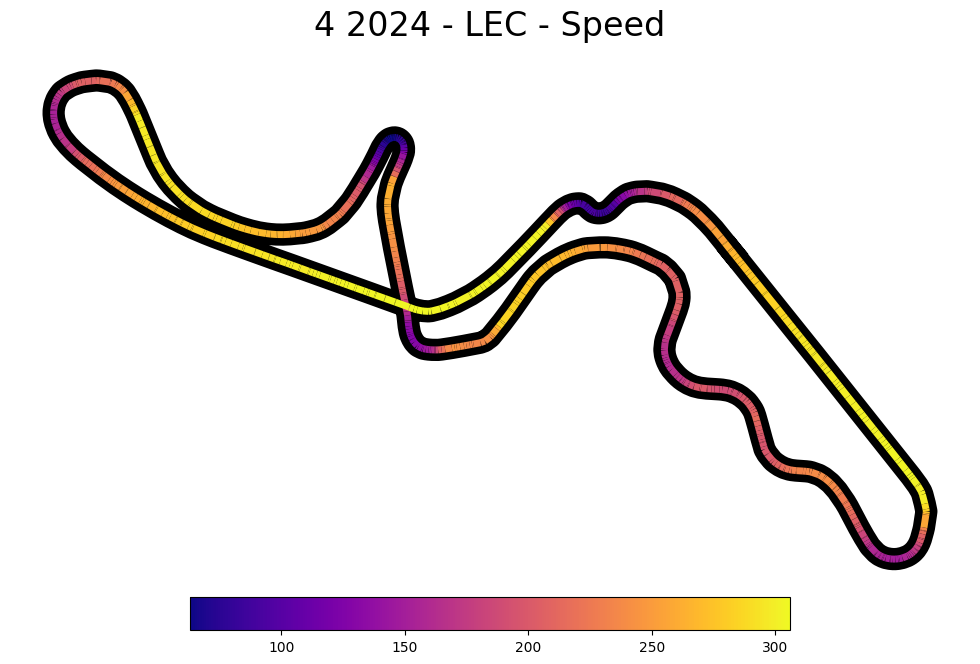

In [2]:
year = 2024
wknd = 4
ses = 'R'
driver = 'LEC'
colormap = mpl.cm.plasma

session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()
lap = session.laps.pick_drivers(driver).pick_fastest()

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{weekend.name} {year} - {driver} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')


# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)


# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")


# Show the plot
plt.show()

PLOT Multipl racer speed profile

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


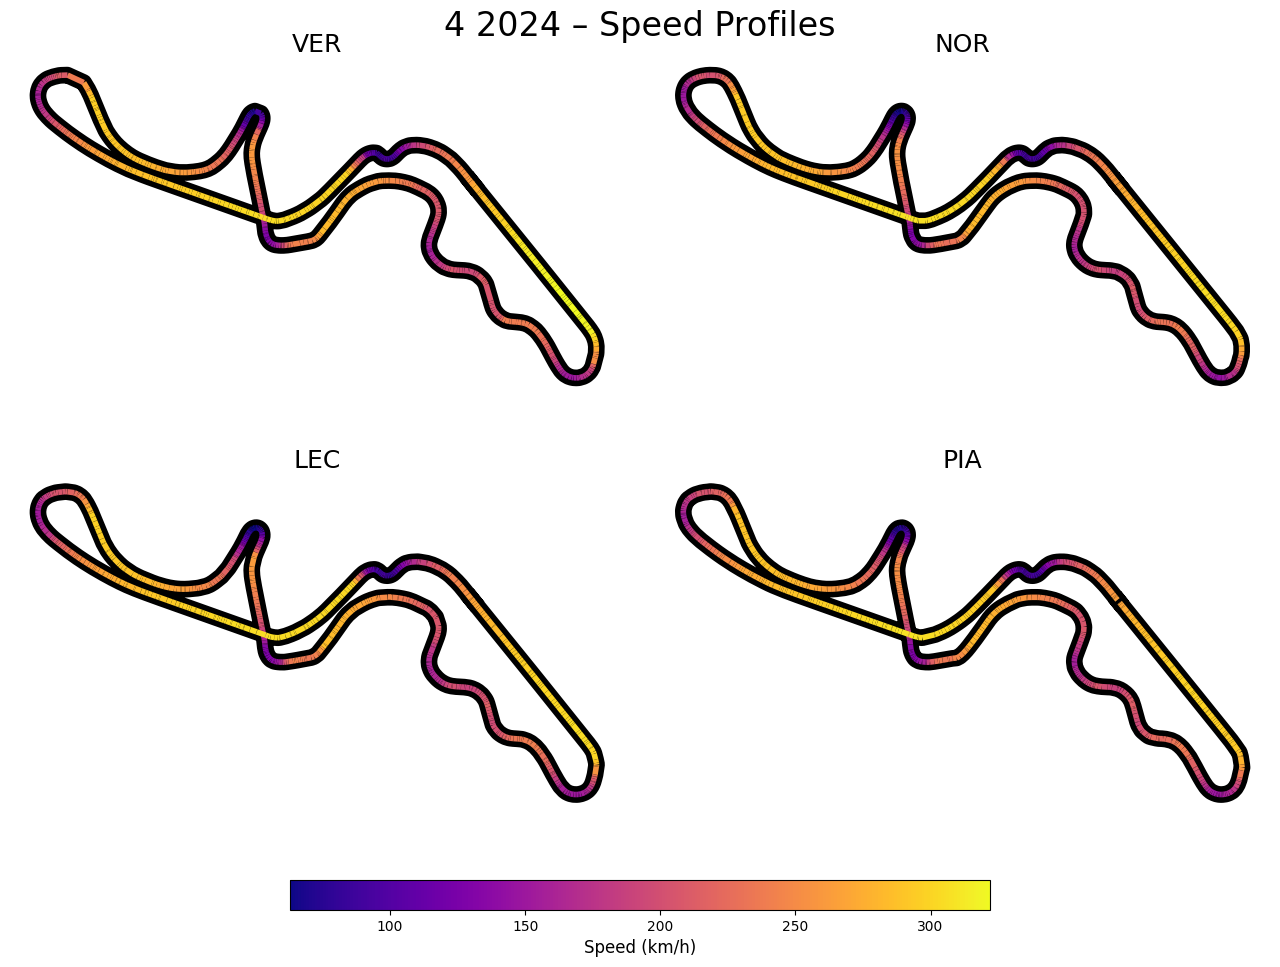

In [34]:
import fastf1 as ff1
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np

# Configuration
year = 2024
wknd = 4
ses = 'R'
drivers = ['VER', 'NOR', 'LEC', 'PIA']
colormap = mpl.cm.plasma

# Load session
session = ff1.get_session(year, wknd, ses)
weekend = session.event
session.load()

# Prepare subplots (2x2)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle(f"{weekend.name} {year} – Speed Profiles", fontsize=24, y=0.95)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, hspace=0.25, wspace=0.05)

# Precompute global min/max speed for consistent color scale
min_speed, max_speed = np.inf, -np.inf
for driver in drivers:
    lap = session.laps.pick_drivers(driver).pick_fastest()
    speed = lap.telemetry['Speed']
    min_speed = min(min_speed, speed.min())
    max_speed = max(max_speed, speed.max())

norm = plt.Normalize(min_speed, max_speed)

# Plot each driver
for i, driver in enumerate(drivers):
    ax = axes[i]
    lap = session.laps.pick_drivers(driver).pick_fastest()
    tel = lap.telemetry

    x = tel['X']
    y = tel['Y']
    color = tel['Speed']

    # Create continuous segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Track outline
    ax.plot(x, y, color='black', linewidth=12, zorder=0)

    # Colored speed line
    lc = LineCollection(segments, cmap=colormap, norm=norm, linewidth=4)
    lc.set_array(color)
    ax.add_collection(lc)

    # Title per subplot
    ax.set_title(driver, fontsize=18)
    ax.axis('off')

# Shared colorbar
cb_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
legend = mpl.colorbar.ColorbarBase(cb_ax, norm=norm, cmap=colormap, orientation='horizontal')
legend.set_label('Speed (km/h)', fontsize=12)

plt.show()
